# Image classification multi-label classification

1. [Introduction](#Introduction)
2. [Prerequisites](#Prequisites)
3. [Data Preparation](#Data-Preparation)
3. [Multi-label Training](#Multi-label-Training)
4. [Inference](#Inference)
5. [Clean-up](#Clean-up)

## Introduction

Welcome to our end-to-end example of multi-label classification using the Sagemaker 1P image classification algorithm. In this demo, we will use the Amazon sagemaker image classification algorithm in transfer learning mode to fine-tune a pre-trained model (trained on imagenet data) to learn to classify a new multi-label dataset. In particular, the pre-trained model will be fine-tuned using [MS-COCO](http://cocodataset.org/#overview) dataset. 

To get started, we need to set up the environment with a few prerequisite steps, for permissions, configurations, and so on.

## Prequisites

### Permissions and environment variables

Here we set up the linkage and authentication to AWS services. There are three parts to this:

* The roles used to give learning and hosting access to your data. This will automatically be obtained from the role used to start the notebook
* The S3 bucket that you want to use for training and model data
* The Amazon sagemaker image classification docker image which need not be changed

In [1]:
%%time
import sagemaker
from sagemaker import get_execution_role

role = get_execution_role()
print(role)

sess = sagemaker.Session()
bucket = 'sagemaker-eyve-us-east-1'
prefix = 'ic-multilabel'

print('using bucket %s'%bucket)

arn:aws:iam::<your arn iam>
using bucket sagemaker-eyve-us-east-1
CPU times: user 813 ms, sys: 85.4 ms, total: 898 ms
Wall time: 1.2 s


In [2]:
from sagemaker.amazon.amazon_estimator import get_image_uri

training_image = get_image_uri(sess.boto_region_name, 'image-classification', repo_version="latest")
print (training_image)

811284229777.dkr.ecr.us-east-1.amazonaws.com/image-classification:latest


## Data Preparation
MS COCO is a large-scale dataset for multiple computer vision tasks, including object detection, segmentation, and captioning. In this notebook, we will use the object detection dataset to construct the multi-label dataset for classification. We will use the 2017 validation set from MS-COCO dataset to train multi-label classifier. MS-COCO dataset consist of images from 80 categories. We will choose 5 categories out of 80 and train the model to learn to classify these 5 categories. These are: 

1. Person
2. Bicycle
3. Car
4. Motorcycle
5. Airplane

An image can contain objects of multiple categories. We first create a dataset with these 5 categories. COCO is a very large dataset, and the purpose of this notebook is to show how multi-label classification works. So, instead we’ll take what COCO calls their validation dataset from 2017, and use this as our only data.  We then split this dataset into a train and holdout dataset for fine tuning the model and testing our final accuracy

The image classification algorithm can take two types of input formats. The first is a [recordio format](https://mxnet.incubator.apache.org/tutorials/basic/record_io.html) and the other is a [lst format](https://mxnet.incubator.apache.org/how_to/recordio.html?highlight=im2rec). We will use the lst file format for training. 

### Dataset License

The annotations in this dataset belong to the COCO Consortium and are licensed under a Creative Commons Attribution 4.0 License. The COCO Consortium does not own the copyright of the images. Use of the images must abide by the Flickr Terms of Use. The users of the images accept full responsibility for the use of the dataset, including but not limited to the use of any copies of copyrighted images that they may create from the dataset. Before you use this data for any other purpose than this example, you should understand the data license, described at http://cocodataset.org/#termsofuse"

In [3]:
import os
import urllib.request

def download(url):
    filename = url.split("/")[-1]
    if not os.path.exists(filename):
        urllib.request.urlretrieve(url, filename)


# MSCOCO validation image files
download('http://images.cocodataset.org/zips/val2017.zip')
download('http://images.cocodataset.org/annotations/annotations_trainval2017.zip')

In [4]:
%%bash
unzip -qo val2017.zip
unzip -qo annotations_trainval2017.zip

### Install tools

We need pycocotools to parse the annotations for the MSCOCO dataset

In [5]:
%%bash
pip -q install pycocotools

You are using pip version 10.0.1, however version 19.0.3 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


### Parse the annotation to create lst file
Use pycocotools to parse the annotation and create the lst file

In [6]:
from pycocotools.coco import COCO
import numpy as np
import os

annFile='./annotations/instances_val2017.json'
coco=COCO(annFile)

catIds = coco.getCatIds()
image_ids_of_cats = []
for cat in catIds:
    image_ids_of_cats.append(coco.getImgIds(catIds=cat))

image_ids = []
labels = []
# use only the first 5 classes
# obtain image ids and labels for images with these 5 classes
cats = [1, 2, 3, 4, 5]
for ind_cat in cats:
    for image_id in image_ids_of_cats[ind_cat-1]:
        if image_id in image_ids:
            labels[image_ids.index(image_id)][ind_cat-1] = 1
        else:
            image_ids.append(image_id)
            labels.append(np.zeros(len(cats), dtype=np.int))
            labels[-1][ind_cat-1] = 1
# Construct the lst file from the image ids and labels
# The first column is the image index, the last is the image filename
# and the second to last but one are the labels
with open('image.lst', 'w') as fp:
    sum_labels = labels[0]
    for ind, image_id in enumerate(image_ids):
        coco_img = coco.loadImgs(image_id)
        image_path = os.path.join(coco_img[0]['file_name'])
        label_h = labels[ind]
        sum_labels += label_h
        fp.write(str(ind) + '\t')
        for j in label_h:
            fp.write(str(j) + '\t')
        fp.write(image_path)
        fp.write('\n')
    fp.close()
print(sum_labels)

loading annotations into memory...
Done (t=0.60s)
creating index...
index created!
[2694  149  536  159   97]


### Create training and validation set
Create training and validation set by splitting the lst file. 

In [7]:
%%bash
shuf image.lst > im.lst
head -n 2500 im.lst > mscocoval2017train.lst
tail -n +2501 im.lst > mscocoval2017val.lst
head mscocoval2017train.lst
wc -l mscocoval2017train.lst
wc -l mscocoval2017val.lst

1843	1	1	0	0	0	000000472623.jpg
1223	1	0	0	0	0	000000569059.jpg
2545	1	0	1	0	0	000000032334.jpg
1617	1	0	0	0	0	000000308165.jpg
245	1	0	0	0	0	000000328430.jpg
214	1	0	0	0	0	000000565877.jpg
225	1	0	0	0	0	000000483999.jpg
1240	1	0	0	0	0	000000233238.jpg
2413	1	0	0	0	0	000000212166.jpg
1685	1	0	0	0	0	000000234607.jpg
2500 mscocoval2017train.lst
469 mscocoval2017val.lst


### Upload the data
Upload the data onto the s3 bucket. The images are uploaded onto train and validation bucket. The lst files are uploaded to train_lst and validation_lst folders. 

In [8]:
# Four channels: train, validation, train_lst, and validation_lst
s3train = 's3://{}/{}/train/'.format(bucket, prefix)
s3validation = 's3://{}/{}/validation/'.format(bucket, prefix)
s3train_lst = 's3://{}/{}/train_lst/'.format(bucket, prefix)
s3validation_lst = 's3://{}/{}/validation_lst/'.format(bucket, prefix)

# upload the image files to train and validation channels
!aws s3 cp val2017 $s3train --recursive --quiet
!aws s3 cp val2017 $s3validation --recursive --quiet

# upload the lst files to train_lst and validation_lst channels
!aws s3 cp mscocoval2017train.lst $s3train_lst --quiet
!aws s3 cp mscocoval2017val.lst $s3validation_lst --quiet

## Multi-label Training
Now that we are done with all the setup that is needed, we are ready to train our object detector. To begin, let us create a ``sageMaker.estimator.Estimator`` object. This estimator will launch the training job.

### Training parameters
There are two kinds of parameters that need to be set for training. The first one are the parameters for the training job. These include:

* **Training instance count**: This is the number of instances on which to run the training. When the number of instances is greater than one, then the image classification algorithm will run in distributed settings. 
* **Training instance type**: This indicates the type of machine on which to run the training. Typically, we use GPU instances for these training 
* **Output path**: This the s3 folder in which the training output is stored

In [9]:
s3_output_location = 's3://{}/{}/output'.format(bucket, prefix)
multilabel_ic = sagemaker.estimator.Estimator(training_image,
                                         role, 
                                         train_instance_count=1, 
                                         train_instance_type='ml.p2.xlarge',
                                         train_volume_size = 50,
                                         train_max_run = 360000,
                                         input_mode= 'File',
                                         output_path=s3_output_location,
                                         sagemaker_session=sess)9

### Algorithm parameters

Apart from the above set of parameters, there are hyperparameters that are specific to the algorithm. These are:

* **num_layers**: The number of layers (depth) for the network. We use 18 in this samples but other values such as 50, 152 can be used.
* **use_pretrained_model**: Set to 1 to use pretrained model for transfer learning.
* **image_shape**: The input image dimensions,'num_channels, height, width', for the network. It should be no larger than the actual image size. The number of channels should be same as the actual image.
* **num_classes**: This is the number of output classes for the dataset. We use 5 classes from MSCOCO and hence it is set to 5
* **mini_batch_size**: The number of training samples used for each mini batch. In distributed training, the number of training samples used per batch will be N * mini_batch_size where N is the number of hosts on which training is run
* **resize**: Resize the image before using it for training. The images are resized so that the shortest side is of this parameter. If the parameter is not set, then the training data is used as such without resizing.
* **epochs**: Number of training epochs
* **learning_rate**: Learning rate for training
* **num_training_samples**: This is the total number of training samples. It is set to 2500 for COCO dataset with the current split
* **use_weighted_loss**: This parameter is used to balance the influence of the positive and negative samples within the dataset.
* **augmentation_type**: This parameter determines the type of augmentation used for training. It can take on three values, 'crop', 'crop_color' and 'crop_color_transform'
* **precision_dtype**: The data type precision used during training. Using ``float16`` can lead to faster training with minimal drop in accuracy, paritcularly on P3 machines. By default, the parameter is set to ``float32``
* **multi_label**: Set multi_label to 1 for multi-label processing

You can find a detailed description of all the algorithm parameters at https://docs.aws.amazon.com/sagemaker/latest/dg/IC-Hyperparameter.html

In [10]:
multilabel_ic.set_hyperparameters(num_layers=18,
                             use_pretrained_model=1,
                             image_shape = "3,224,224",
                             num_classes=5,
                             mini_batch_size=128,
                             resize=256,
                             epochs=5,
                             learning_rate=0.001,
                             num_training_samples=2500,
                             use_weighted_loss=1,
                             augmentation_type = 'crop_color_transform',
                             precision_dtype='float32',
                             multi_label=1)

### Input data specification
Set the data type and channels used for training. In this training, we use application/x-image content type that require individual images and lst file for data input. In addition, Sagemaker image classification algorithm supports application/x-recordio format which can be used for larger datasets. 

In [11]:
train_data = sagemaker.session.s3_input(s3train, distribution='FullyReplicated', 
                        content_type='application/x-image', s3_data_type='S3Prefix')
validation_data = sagemaker.session.s3_input(s3validation, distribution='FullyReplicated', 
                             content_type='application/x-image', s3_data_type='S3Prefix')
train_data_lst = sagemaker.session.s3_input(s3train_lst, distribution='FullyReplicated', 
                        content_type='application/x-image', s3_data_type='S3Prefix')
validation_data_lst = sagemaker.session.s3_input(s3validation_lst, distribution='FullyReplicated', 
                             content_type='application/x-image', s3_data_type='S3Prefix')
data_channels = {'train': train_data, 'validation': validation_data, 'train_lst': train_data_lst, 
                 'validation_lst': validation_data_lst}

### Start the training
Start training by calling the fit method in the estimator

In [12]:
multilabel_ic.fit(inputs=data_channels, logs=True)

INFO:sagemaker:Creating training-job with name: image-classification-2019-04-06-17-11-23-372


2019-04-06 17:11:23 Starting - Starting the training job...
2019-04-06 17:11:25 Starting - Launching requested ML instances......
2019-04-06 17:12:27 Starting - Preparing the instances for training......
2019-04-06 17:13:26 Downloading - Downloading input data.........
2019-04-06 17:15:19 Training - Downloading the training image...
2019-04-06 17:15:54 Training - Training image download completed. Training in progress.
Docker entrypoint called with argument(s): train
[04/06/2019 17:15:48 INFO 140703931918144] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/image_classification/default-input.json: {u'beta_1': 0.9, u'gamma': 0.9, u'beta_2': 0.999, u'optimizer': u'sgd', u'use_pretrained_model': 0, u'eps': 1e-08, u'epochs': 30, u'lr_scheduler_factor': 0.1, u'num_layers': 152, u'image_shape': u'3,224,224', u'precision_dtype': u'float32', u'mini_batch_size': 32, u'weight_decay': 0.0001, u'learning_rate': 0.1, u'momentum': 0}
[04/06/2019 17:15:48 INFO 14070393191814

# Inference

***

A trained model does nothing on its own. We now want to use the model to perform inference. For this example, that means predicting the class of the image. You can deploy the created model by using the deploy method in the estimator

In [19]:
ic_classifier = multilabel_ic.deploy(initial_instance_count = 1,
                                          instance_type = 'ml.m4.xlarge')

INFO:sagemaker:Creating model with name: image-classification-2019-04-07-09-02-29-948
INFO:sagemaker:Creating endpoint with name image-classification-2019-04-06-17-11-23-372


----------------------------------------------------------------------------------------!

### Download test image

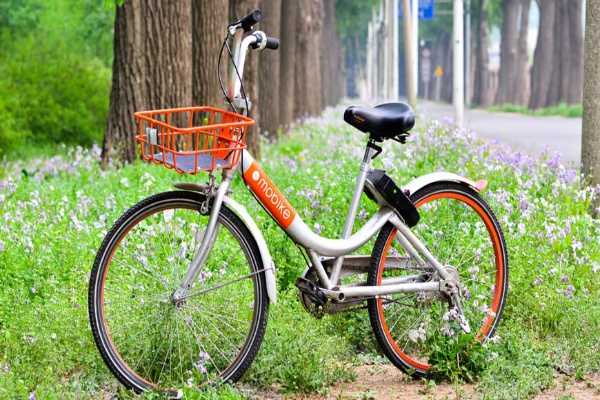

In [17]:
%matplotlib inline  
!wget -q -O /tmp/test.jpg https://www.thegef.org/sites/default/files/Mobike_blog2_870_0.jpg
    
import cv2
# resize image size for inference
file_name = '/tmp/test.jpg'
im = cv2.imread(file_name)
im = cv2.resize(im, (600, 400))
cv2.imwrite(file_name, im)

# display test image
from IPython.display import Image, display
img = Image(file_name) 
display(img)

### Evaluation

Evaluate the image through the network for inference. The network outputs class probabilities for all the classes. As can be seen from this example, the network output is pretty good even with training for only 5 epochs

In [20]:
import json

with open(file_name, 'rb') as image:
    f = image.read()
    b = bytearray(f)
ic_classifier.content_type = 'application/x-image'
results = ic_classifier.predict(b)
prob = json.loads(results)
classes = ['Person', 'Bicycle', 'Car', 'Motorcycle', 'Airplane']
for idx, val in enumerate(classes):
    print('%s:%f '%(classes[idx], prob[idx]), end='')

Person:0.836123 Bicycle:0.994269 Car:0.791842 Motorcycle:0.873515 Airplane:0.013207 

## Clean up
You can use the following command to delete the endpoint. The endpoint that is created above is persistent and would consume resources till it is deleted. It is good to delete the endpoint when it is not used

In [16]:
#ic_classifier.delete_endpoint()

INFO:sagemaker:Deleting endpoint configuration with name: image-classification-2019-04-06-17-11-23-372
INFO:sagemaker:Deleting endpoint with name: image-classification-2019-04-06-17-11-23-372
